### Import packages and functions

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from Bio import Entrez

In [3]:
def get_ncbi_summary(gene_name):
    """Get NCBI gene summary using Entrez."""
    Entrez.email = "she4@mdanderson.org"
    try:
        handle = Entrez.esearch(db="gene", term=f"{gene_name}[Gene Name] AND human[Organism]")
        record = Entrez.read(handle)
        if not record["IdList"]:
            return "Gene not found"
    
        gene_id = record["IdList"][0]
        handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
        records = Entrez.read(handle)
        
        summary = ""
        if "Entrezgene_summary" in records[0]:
            summary = records[0]["Entrezgene_summary"]
        return summary if summary else "No summary available"
    except Exception as e:
        return f"Error fetching gene data: {str(e)}"

In [4]:
import requests
import re

def get_msigdb_description(gene_set_name):
    url = f"https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/{gene_set_name}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        full_pattern = r'<th>Full description or abstract</th>\s*<td[^>]*>(.+?)</td>'
        brief_pattern = r'<th>Brief description</th>\s*<td[^>]*>(.+?)</td>'
        
        full_match = re.search(full_pattern, response.text, re.DOTALL)
        brief_match = re.search(brief_pattern, response.text, re.DOTALL)
        
        if full_match and full_match.group(1) != '&nbsp;':
            description = full_match.group(1)
        elif brief_match:
            description = brief_match.group(1)
        else:
            return "Description not found"
        
        description = description.strip(' "')
        description = re.sub(r'<[^>]+>', '', description)
        return description
            
    except Exception as e:
        return f"Error: {str(e)}"

In [5]:
from groq import Groq
from Bio import Entrez

client = Groq(api_key="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")
def get_pathway_description(pathway):
    try:
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a biologist providing detailed descriptions of biological pathways."},
                {"role": "user", "content": f"Describe the {pathway} pathway in a short paragraph, including molecular mechanisms and key components."}
            ],
            model="llama3-70b-8192",
            temperature=0,
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {str(e)}"

In [6]:
def generate_embedding(text):
    """Generate 2D embedding using BERT."""
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Get the embedding from the last hidden state
    embeddings_2d = embeddings[:, :2]  # Reduce to 2D using first two dimensions
    return embeddings_2d.numpy()

In [7]:
def get_gene_embeddings(gene_list):
    coordinates = []
    for gene in gene_list:
        summary = get_ncbi_summary(gene)
        embedding = generate_embedding(summary)
        coordinates.append({
            'gene': gene,
            'coords': embedding[0].tolist()
        })
    return coordinates

def get_msigdb_embeddings(pathway_list):
    coordinates = []
    for pathway in pathway_list:
        description = get_msigdb_description(pathway)
        embedding = generate_embedding(description)
        coordinates.append({
            'pathway': pathway,
            'coords': embedding[0].tolist()
        })
    return coordinates

def get_pathway_embeddings(pathway_list):
    coordinates = []
    for pathway in pathway_list:
        description = get_pathway_description(pathway)
        # description = pathway
        embedding = generate_embedding(description)
        coordinates.append({
            'pathway': pathway,
            'coords': embedding[0].tolist()
        })
    return coordinates

In [8]:
import pandas as pd

### Get gene set genes, get NCBI summary and embedding from biobert
def process_excel(file_path):
    xl = pd.ExcelFile(file_path)
    gene_sets = {}
    for sheet_name in xl.sheet_names:
        df = xl.parse(sheet_name)
        for column in df.columns:
            gene_set_name = f"{sheet_name}_{column}"
            genes = df[column].dropna().tolist()
            gene_sets[gene_set_name] = genes
    return gene_sets
file_path = '/Volumes/she4/knowledgegraph/data/validation/tirosh_MPs.xlsx'
result = process_excel(file_path)

### Get KG pathways, get summary from llama3 and embedding from biobert
def process_excel(file_path):
    xl = pd.ExcelFile(file_path)
    gene_sets = {}
    df = xl.parse('Table4')
    for column in df.columns:
        gene_set_name = column
        genes = df[column].dropna().tolist()
        gene_sets[gene_set_name] = genes
    return gene_sets
file_path = '/Users/she4/Library/CloudStorage/OneDrive-InsideMDAnderson/ken/knowledgegraph/Tables.xlsx'
anntation = process_excel(file_path)

### Get ORA pathways, get summary from llama3 and embedding from biobert
def process_csv(file_path):
    df = pd.read_csv(file_path)
    gene_sets = {}
    for column in df.columns:
        gene_set_name = column
        genes = df[column].dropna().tolist()
        gene_sets[gene_set_name] = genes
    return gene_sets
file_path = '/Volumes/she4/knowledgegraph/result/ORA_genesetannotation_small.csv'
ORA_annotation = process_csv(file_path)

In [ ]:
gs = result.keys()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
plt.rcParams['pdf.fonttype'] = 42

def detect_outliers(x, y, threshold=2):
    """
    Detect outliers using z-score method
    Returns boolean mask where True indicates outlier points
    """
    points = np.column_stack((x, y))
    z_scores = np.abs(zscore(points, axis=0))
    outliers = np.any(z_scores > threshold, axis=1)
    return outliers

def plot_combined_embeddings(gene_coords, pathway_coords, ora_pathway_coordinates, dir, outlier_threshold=2,i):
    plt.figure(figsize=(10, 8))
    
    gene_x = [coord['coords'][0] for coord in gene_coords]
    gene_y = [coord['coords'][1] for coord in gene_coords]
    plt.scatter(gene_x, gene_y, color='red', alpha=0.6, label='Genes')
    
    pathway_x = [coord['coords'][0] for coord in pathway_coords]
    pathway_y = [coord['coords'][1] for coord in pathway_coords]
    plt.scatter(pathway_x, pathway_y, color='blue', alpha=0.6, label='KG Pathways')
    
    orapathway_x = [coord['coords'][0] for coord in ora_pathway_coordinates]
    orapathway_y = [coord['coords'][1] for coord in ora_pathway_coordinates]
    plt.scatter(orapathway_x, orapathway_y, color='blue', alpha=0.6, label='KG Pathways')
    outliers = detect_outliers(orapathway_x, orapathway_y, outlier_threshold)
    
    plt.scatter(np.array(orapathway_x)[~outliers], 
               np.array(orapathway_y)[~outliers], 
               color='green', 
               alpha=0.6, 
               label='ORA Pathways')
    
    plt.scatter(np.array(orapathway_x)[outliers], 
               np.array(orapathway_y)[outliers], 
               color='lime', 
               alpha=1.0, 
               s=100,
               marker='*',
               label='ORA Outliers')
    
    for index, coord in enumerate(ora_pathway_coordinates):  # Add labels for outlier points
        if outliers[index]:
            x = coord['coords'][0]
            y = coord['coords'][1]
            pathway_name = coord['pathway']
            
            display_name = pathway_name.replace('HALLMARK_', '').replace('REACTOME_', '')
            display_name = display_name.replace('WP_', '').replace('_', ' ').title()
            
            plt.annotate(display_name, 
                        (x, y),
                        xytext=(5, 5),
                        textcoords='offset points',
                        bbox=dict(facecolor='white', 
                                alpha=0.7,
                                edgecolor='none',
                                pad=1),
                        fontsize=8,
                        ha='left',
                        va='bottom')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(f'Genes and Pathways Embedding Space for {i}')
    plt.legend()
    plt.grid(True)
    plt.savefig(dir,
                format='pdf',
                dpi=300,
                bbox_inches='tight')
    plt.close()

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean

def calculate_centroid(coordinates):
    coords = np.array([coord['coords'] for coord in coordinates])
    return np.mean(coords, axis=0)

def calculate_wcss(coordinates, centroid):
    coords = np.array([coord['coords'] for coord in coordinates])
    return sum(euclidean(point, centroid)**2 for point in coords)

def calculate_metrics(gene_coords, pathway_coords, ora_pathway_coords):

    gene_centroid = calculate_centroid(gene_coords)
    pathway_centroid = calculate_centroid(pathway_coords)
    ora_pathway_centroid = calculate_centroid(ora_pathway_coords)
    
    pathway_to_gene_dist = euclidean(pathway_centroid, gene_centroid)
    ora_to_gene_dist = euclidean(ora_pathway_centroid, gene_centroid)
    
    pathway_wcss = calculate_wcss(pathway_coords, pathway_centroid)
    ora_pathway_wcss = calculate_wcss(ora_pathway_coords, ora_pathway_centroid)
    
    return {
        'pathway_gene_distance': pathway_to_gene_dist,
        'ora_gene_distance': ora_to_gene_dist,
        'pathway_wcss': pathway_wcss,
        'ora_pathway_wcss': ora_pathway_wcss
    }

In [ ]:
metrics_df = pd.DataFrame(columns=[
    'iteration',
    'pathway_gene_distance',
    'ora_gene_distance',
    'pathway_wcss',
    'ora_pathway_wcss'
])

In [ ]:
for i in gs:
    
    gene_coordinates = get_gene_embeddings(result[i])
    pathway_coordinates = get_pathway_embeddings(anntation[f'pagerank_analysis_results_{i}'])
    ora_pathway_coordinates = get_msigdb_embeddings(ORA_annotation[i])

    plot_combined_embeddings(gene_coordinates, pathway_coordinates,ora_pathway_coordinates,
                             dir=f'/users/she4/desktop/{i}.pdf')
    
    metrics = calculate_metrics(
        gene_coords=gene_coordinates,
        pathway_coords=pathway_coordinates,
        ora_pathway_coords=ora_pathway_coordinates
    )
    metrics_df.loc[len(metrics_df)] = {
        'iteration': i,
        'pathway_gene_distance': metrics['pathway_gene_distance'],
        'ora_gene_distance': metrics['ora_gene_distance'],
        'pathway_wcss': metrics['pathway_wcss'],
        'ora_pathway_wcss': metrics['ora_pathway_wcss']
    }
    print(i)

metrics_df.to_csv('/users/she4/Desktop/clustering_metrics.csv', index=False)

In [ ]:
import pandas as pd
df = pd.read_csv("/Users/she4/Library/CloudStorage/OneDrive-InsideMDAnderson/ken/knowledgegraph/FigureS2/clustering_metrics.csv")
df = df.copy()
def get_cell_type(pathway):
    if pathway.startswith('B_cells'):
        return 'B cells'
    elif pathway.startswith('CD4'):
        return 'CD4 T cells'
    elif pathway.startswith('Macro'):
        return 'Macrophages'
    elif pathway.startswith('CD8'):
        return 'CD8 T cells'
    elif pathway.startswith('xianli'):
        return 'CD8 T cells'
    elif pathway.startswith('NK'):
        return 'NK cells'
    return 'Other'
df['cell_type'] = df['iteration'].apply(get_cell_type)
df

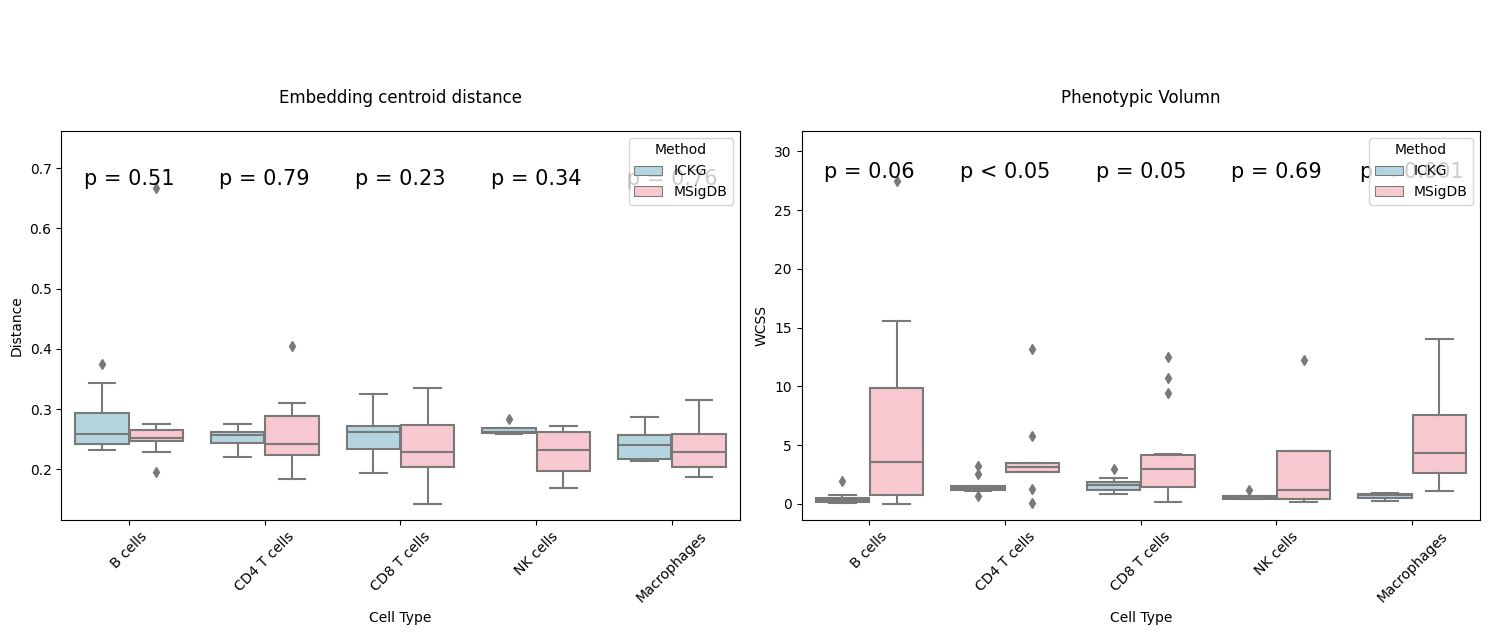

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42
def add_stats(ax, data, x_col, y_col, hue_col):
    cell_types = data[x_col].unique()
    y_max = data[y_col].max()
    y_min = data[y_col].min()
    y_range = y_max - y_min
    
    for i, cell_type in enumerate(cell_types):
        group1 = data[(data[x_col] == cell_type) & (data[hue_col] == 'ICKG')][y_col]
        group2 = data[(data[x_col] == cell_type) & (data[hue_col] == 'MSigDB')][y_col]
        stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        if p_value < 0.001:
            p_str = 'p < 0.001'
        elif p_value < 0.01:
            p_str = 'p < 0.01'
        elif p_value < 0.05:
            p_str = 'p < 0.05'
        else:
            p_str = f'p = {p_value:.2f}'
        
        y_pos = y_max + y_range * 0.01
        ax.text(i, y_pos, p_str, horizontalalignment='center', fontsize=15)

gene_dist_df = pd.melt(df, 
                       id_vars=['cell_type'],
                       value_vars=['pathway_gene_distance', 'ora_gene_distance'],
                       var_name='Method',
                       value_name='distance')
gene_dist_df['Method'] = gene_dist_df['Method'].map({
    'pathway_gene_distance': 'ICKG',
    'ora_gene_distance': 'MSigDB'
})

wcss_df = pd.melt(df,
                  id_vars=['cell_type'],
                  value_vars=['pathway_wcss', 'ora_pathway_wcss'],
                  var_name='Method',
                  value_name='wcss')
wcss_df['Method'] = wcss_df['Method'].map({
    'pathway_wcss': 'ICKG',
    'ora_pathway_wcss': 'MSigDB'
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
colors = {'ICKG': 'lightblue', 'MSigDB': 'pink'}
sns.boxplot(data=gene_dist_df, x='cell_type', y='distance', hue='Method', 
            palette=colors, 
            ax=ax1)
sns.boxplot(data=wcss_df, x='cell_type', y='wcss', hue='Method',
            palette=colors,
            ax=ax2)

add_stats(ax1, gene_dist_df, 'cell_type', 'distance', 'Method')
add_stats(ax2, wcss_df, 'cell_type', 'wcss', 'Method')

ax1.set_title('Embedding centroid distance', pad=20)
ax1.set_xlabel('Cell Type')
ax1.set_ylabel('Distance')
ax1.tick_params(axis='x', rotation=45)

ax2.set_title('Phenotypic Volumn', pad=20)
ax2.set_xlabel('Cell Type')
ax2.set_ylabel('WCSS')
ax2.tick_params(axis='x', rotation=45)

ax1.set_ylim(ax1.get_ylim()[0], ax1.get_ylim()[1] * 1.1)
ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1] * 1.1)
plt.suptitle(' ', y=1.05, fontsize=14)
plt.tight_layout()
plt.savefig('/Users/she4/Desktop/pathway_metrics_boxplots.pdf', 
            format='pdf',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1)
plt.show()

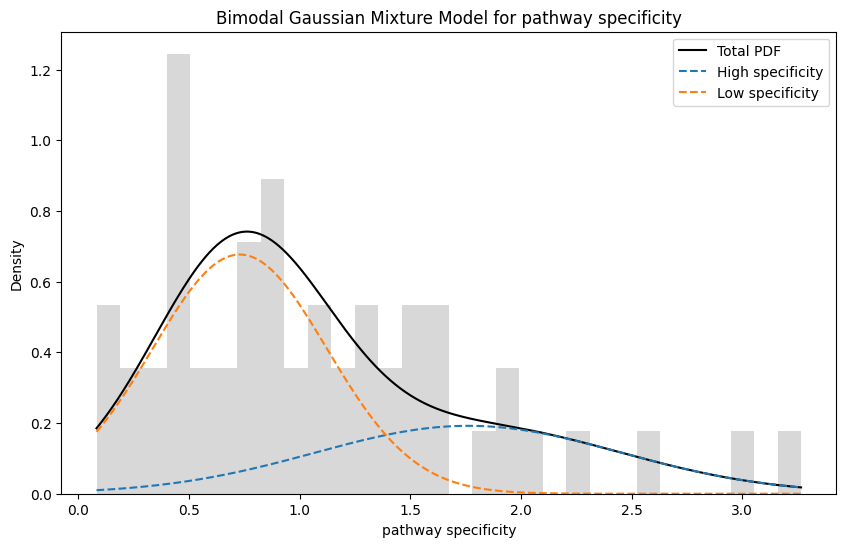

In [64]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = "/Users/she4/Library/CloudStorage/OneDrive-InsideMDAnderson/ken/knowledgegraph/FigureS2/clustering_metrics.csv"
data = pd.read_csv(file_path)

wcss_data = data['pathway_wcss'].values.reshape(-1, 1)

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(wcss_data)
means = gmm.means_.flatten()
high = 'High' if means[0] > means[1] else 'Low'
low = 'Low' if high == 'High' else 'High'
x = np.linspace(wcss_data.min(), wcss_data.max(), 1000).reshape(-1, 1)
log_prob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(log_prob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(10, 6))
plt.hist(wcss_data, bins=30, density=True, alpha=0.3, color='grey')
plt.plot(x, pdf, '-k', label='Total PDF')
plt.plot(x, pdf_individual[:, 0], '--', label=f'{high} specificity')
plt.plot(x, pdf_individual[:, 1], '--', label=f'{low} specificity')
plt.title('Bimodal Gaussian Mixture Model for pathway specificity')
plt.xlabel('pathway specificity')
plt.ylabel('Density')
plt.legend()
plt.show()


In [55]:
# median_wcss = np.percentile(wcss_data, 70)
# labels = (wcss_data > median_wcss).astype(int)
# high_group_iterations = data.loc[labels == 1, 'iteration']
# print("Iterations for the 'high wcss (low specificity)' group:")
# print(high_group_iterations)

labels = gmm.predict(wcss_data)
means = gmm.means_.flatten()
high_label = 1 if means[0] < means[1] else 0
high_group_iterations = data.loc[labels == high_label, 'iteration']
print("Iterations for the 'high specificity' group:")
print(high_group_iterations)

Iterations for the 'high specificity' group:
9        B_cells_Respiration
13            CD4_Cell_cycle
14             CD4_Cytotoxic
18                CD4_Naive2
20            CD4_Stress_HSP
21             CD8_Cytotoxic
22            CD8_Cell_cycle
23         CD8_Memory_Naive1
24            CD8_Interferon
26                CD8_Naive2
29            CD8_Heat_shock
31           CD8_Dysfunction
33      xianli-tcr_PDAC-Meng
34    xianli-tcr_Lung-Caushi
35         xianli-tcr_Lowery
Name: iteration, dtype: object


In [82]:
import requests
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

def fetch_string_interactions(gene_list, species=9606):
    """ Fetch interactions from STRING database for a list of genes. """
    string_api_url = "https://string-db.org/api" # query the ppi network
    output_format = "tsv-no-header"
    method = "network"
    request_url = f"{string_api_url}/{output_format}/{method}"
    params = {
        "identifiers": "\r".join(gene_list),  
        "species": species,  
        "network_type": "functional",  
        "caller_identity": "your_app_name"  
    }
    response = requests.post(request_url, data=params)
    if response.ok:
        lines = response.text.strip().split("\n")
        data = [line.split("\t") for line in lines]
        return data
    else:
        raise Exception("Failed to retrieve data from STRING API")

def create_network(data):
    G = nx.Graph()
    for item in data:
        node_a, node_b, combined_score = item[2], item[3], float(item[-1])
        G.add_edge(node_a, node_b, weight=combined_score)
    return G

def plot_network(G):
    pos = nx.spring_layout(G)  
    nx.draw(G, pos, node_size=700, with_labels=True, node_color='lightblue', font_size=8)
    plt.show()

In [106]:
import pandas as pd
import networkx as nx
import openpyxl
import networkx.algorithms.community as nx_comm

def calculate_network_metrics(G):
    density = nx.density(G)
    clustering_coefficient = nx.average_clustering(G)
    communities = nx_comm.greedy_modularity_communities(G)
    modularity = nx_comm.modularity(G, communities)
    return density, clustering_coefficient,modularity


file_path = "/Volumes/she4/knowledgegraph/data/validation/tirosh_MPs.xlsx"
sheets_to_read = ["B_cells", "CD4", "CD8", "xianli-tcr", "NK-genesets", "Macrophages"]
xls = pd.ExcelFile(file_path)
results = []

for sheet_name in sheets_to_read:
    if sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        for column in df.columns:
            gene_set = df[column].dropna().unique().tolist()
            interactions = fetch_string_interactions(gene_set)
            G = create_network(interactions)
            density, clustering_coefficient,modularity = calculate_network_metrics(G)
            
            results.append({
                "Gene Set Name": sheet_name+"_"+column,
                "Density": density,
                "Clustering Coefficient": clustering_coefficient,
                "Modularity": modularity
            })


result_df = pd.DataFrame(results)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
plt.rcParams['pdf.fonttype'] = 42

result_df['Group'] = ['High' if gene_set in list(high_group_iterations) else 'Low' for gene_set in result_df['Gene Set Name']]

high_density = result_df[result_df['Group'] == 'High']['Density']
low_density = result_df[result_df['Group'] == 'Low']['Density']
stat_density, p_density = mannwhitneyu(high_density, low_density)

high_clustering = result_df[result_df['Group'] == 'High']['Clustering Coefficient']
low_clustering = result_df[result_df['Group'] == 'Low']['Clustering Coefficient']
stat_clustering, p_clustering = mannwhitneyu(high_clustering, low_clustering)

high_modularity = result_df[result_df['Group'] == 'High']['Modularity']
low_modularity = result_df[result_df['Group'] == 'Low']['Modularity']
stat_modularity, p_modularity = mannwhitneyu(high_modularity, low_modularity)

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
sns.boxplot(x='Group', y='Density', data=result_df)
plt.title('Density Comparison')
plt.figtext(0.25, 0.9, f'P-value: {p_density:.4f}', ha='center')

plt.subplot(1, 3, 2)
sns.boxplot(x='Group', y='Clustering Coefficient', data=result_df)
plt.title('Clustering Coefficient Comparison')
plt.figtext(0.75, 0.9, f'P-value: {p_clustering:.4f}', ha='center')

plt.subplot(1, 3, 3)
sns.boxplot(x='Group', y='Modularity', data=result_df)
plt.title('Modularity Comparison')
plt.figtext(0.75, 0.9, f'P-value: {p_modularity:.4f}', ha='center')

# plt.tight_layout()
plt.show()
# plt.savefig("/Users/she4/Library/CloudStorage/OneDrive-InsideMDAnderson/ken/knowledgegraph/Figure5/WSCC_highvslow.pdf", 
#             format='pdf', bbox_inches='tight', dpi=300)